# Les Houches Large Scale Structure Hands on

## Creating matter density fields

Based on Quijote tutorial: Creating Density Fields

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.flatironinstitute.org/v2/user/fvillaescusa/Quijote?filepath=/Tutorials/Density_fields.ipynb)

In [52]:
import numpy as np
import readgadget
import matplotlib.pyplot as plt
from pylab import *

Define the value of the parameters

In [53]:
cos='fiducial'
realisation=0
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}

snapnum=4#2:z=1,4:z=0
redshift = z_dict[snapnum]

print('picking snapshot file',cos,'realisation',realisation,'redshift',redshift)
snapshot = 'Data/Snapshots/'+cos+'/'+str(realisation)+'/snapdir_00'+str(snapnum)+'/snap_00'+str(snapnum)
verbose  = True   #whether to print information about the progress
ptype    = [1]    #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

picking snapshot file fiducial realisation 0 redshift 0.0


Read the header and the particle positions

In [54]:
# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
redshift = header.redshift     #redshift of the snapshot
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Nall     = header.nall         #Total number of particles
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
# redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h

Print some information about the data

In [55]:
print('BoxSize: %.3f Mpc/h'%BoxSize)
print('Redshift: %.3f'%redshift)
print('%.3f < X < %.3f'%(np.min(pos[:,0]), np.max(pos[:,0])))
print('%.3f < Y < %.3f'%(np.min(pos[:,1]), np.max(pos[:,1])))
print('%.3f < Z < %.3f'%(np.min(pos[:,2]), np.max(pos[:,2])))

BoxSize: 1000.000 Mpc/h
Redshift: 0.000
0.000 < X < 999.992
0.000 < Y < 999.992
0.000 < Z < 999.992


Now construct the 3D density field

In [56]:
import MAS_library as MASL
# construct 3D density field
N_grid     = 256    #the density field will have N_grid^3 voxels
MAS      = 'CIC'  #Mass-assignment scheme:'NGP', 'CIC', 'TSC', 'PCS'
rho = np.zeros((N_grid,N_grid,N_grid), dtype=np.float32)
MASL.MA(pos, rho, BoxSize, MAS, verbose=verbose)
# at this point, delta contains the effective number of particles in each voxel
# now compute overdensity
print(np.mean(rho))

print('%.3f < delta < %.3f'%(np.min(rho), np.max(rho)))
print('<rho> = %.3f'%np.mean(rho))
print('shape of the matrix:', rho.shape)
print('density field data type:', rho.dtype)


Using CIC mass assignment scheme
Time taken = 9.146 seconds

7.999999
0.092 < delta < 2135.010
<rho> = 8.000
shape of the matrix: (256, 256, 256)
density field data type: float32


We can make some tests to make sure the density field has been computed properly

In [57]:
# the sum of the values in all voxels should be equal to the number of particles
print('%.3f should be equal to\n%.3f'%(np.sum(rho, dtype=np.float64), pos.shape[0]))
rho /= np.mean(rho, dtype=np.float64)

134217727.964 should be equal to
134217728.000


Lets take a slice in the cube and plot it

In [34]:
# the box is 1000 Mpc/h and every voxel has ~2 Mpc/h size. We can take ~5 slices to consider a region with a ~10 Mpc/h witdh
mean_density = np.mean(rho[:5,:,:],axis=0) #Take the first 5 component along the first axis and compute the mean value
print('Image shape:',mean_density.shape)
print('%.3e < mass < %.3e'%(np.min(mean_density), np.max(mean_density)))

# now lets consider the particles in that slide
indexes = np.where((pos[:,0]<10))
pos_slide = pos[indexes]
print('%.3f < X < %.3f'%(np.min(pos_slide[:,0]), np.max(pos_slide[:,0])))
print('%.3f < Y < %.3f'%(np.min(pos_slide[:,1]), np.max(pos_slide[:,1])))
print('%.3f < Z < %.3f'%(np.min(pos_slide[:,2]), np.max(pos_slide[:,2])))

Image shape: (128, 128)
1.878e-01 < mass < 8.265e+00
0.000 < X < 10.000
0.000 < Y < 999.992
0.000 < Z < 999.992


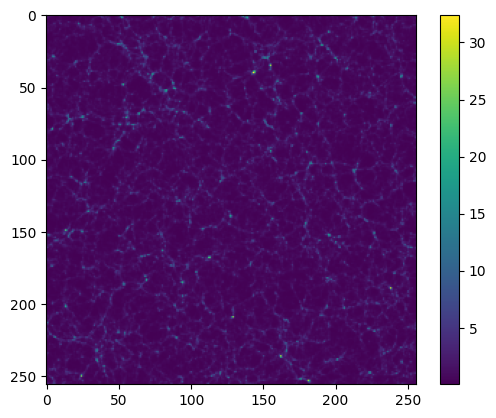

In [58]:
mean_density = np.mean(rho[:5,:,:],axis=0) #Take the first 5 component along the first axis and compute the mean value

plt.imshow(mean_density.T)
plt.colorbar()
plt.show()

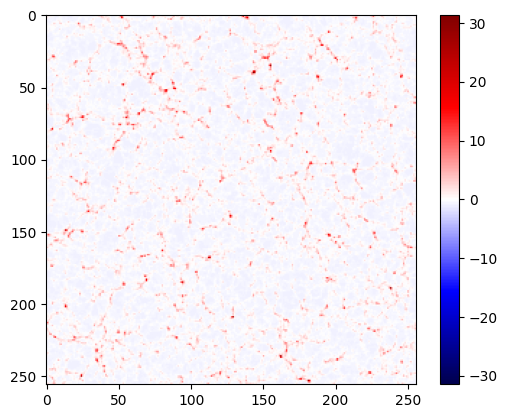

In [60]:

plt.imshow((mean_density-1).T,cmap='seismic',vmin=-np.max(mean_density-1),vmax=np.max(mean_density-1))
plt.colorbar()
plt.show()

If needed, the overdensity is easy to calculate

## One-point Statistics

In [26]:
np.min(rho),np.max(rho)

(np.float32(0.15472266), np.float32(12.129037))

In [13]:
bin_edges=np.logspace(np.log10(0.01), np.log10(100), num=100, endpoint=True, base=10.0, dtype=None, axis=0)-1

Text(0, 0.5, '$P(\\delta)$')

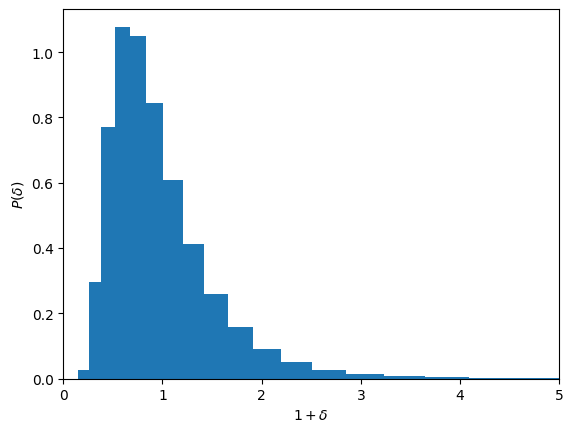

In [27]:
counts,bin_edges,_=plt.hist(rho.flatten(),bins=bin_edges,density=True)
plt.xlim(0,5)
plt.xlabel(r'$1+\delta$')
plt.ylabel(r'$P(\delta)$')
# plt.xscale('log')
# plt.xscale('log')

In [19]:
BoxSize/N_grid

np.float64(7.8125)

In [29]:
np.mean((rho-1)**3)

np.float32(0.41369668)

In [30]:
np.var((rho-1))

np.float32(0.3214193)

In [31]:
34/7*np.var((rho-1))**2

np.float32(0.5017932)

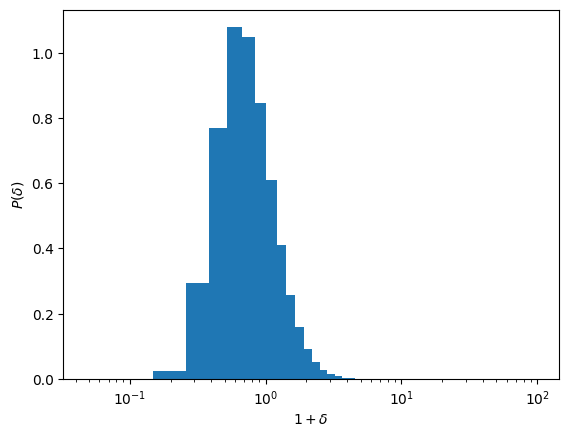

In [28]:
counts,bin_edges,_=plt.hist(rho.flatten(),bins=bin_edges,density=True)
# plt.xlim(0,5)
plt.xlabel(r'$1+\delta$')
plt.ylabel(r'$P(\delta)$')
plt.xscale('log')
# plt.xscale('log')

## Power spectra

In [61]:
import Pk_library as PKL
threads=25
axis=0
# compute power spectrum
Pk = PKL.Pk(rho-1, BoxSize, axis, MAS, threads, verbose)

# 3D P(k)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole
Pk2     = Pk.Pk[:,1] #quadrupole
Pk4     = Pk.Pk[:,2] #hexadecapole
# Pkphase = Pk.Pkphase #power spectrum of the phases
# Nmodes  = Pk.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 1.28
Time taken = 2.19 seconds


In [38]:
import cosmology_library as CL
# read linear matter Pk
f_Pk   = 'Data/Linear_Pk/'+cos+'/CAMB_TABLES/CAMB_matterpow_0.dat'  #file with linear Pk
k_lin, Pk_lin = np.loadtxt(f_Pk, unpack=True)

z=0
# find the non-linear power spectrum from halofit
Pk_nl = CL.Halofit_12(Omega_m, Omega_l, z, k_lin, Pk_lin)

Pk_13   = np.loadtxt('P13T.dat')  #file with SPT 13
Pk_22   = np.loadtxt('P22T.dat')  #file with SPT 22


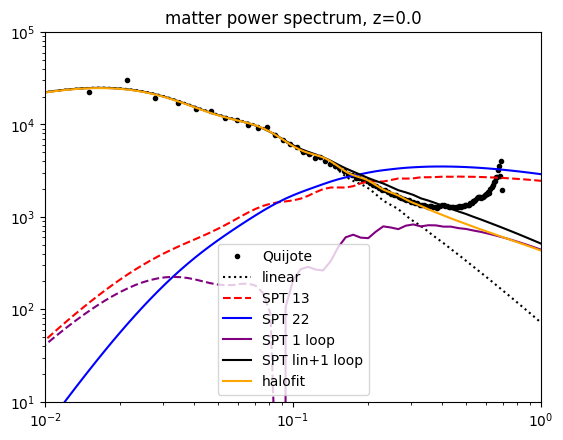

In [45]:
plt.plot(k,Pk0,'k.',label='Quijote')
plt.plot(k_lin,Pk_lin,'k:',label='linear')
plt.plot(Pk_13[:,0],-Pk_13[:,1],'r--',label='SPT 13')
plt.plot(Pk_22[:,0],Pk_22[:,1],'b-',label='SPT 22')
plt.plot(Pk_22[:,0],+Pk_13[:,1]+Pk_22[:,1],color='purple',label='SPT 1 loop')
plt.plot(Pk_22[:,0],-(Pk_13[:,1]+Pk_22[:,1]),color='purple',linestyle='--')
plt.plot(Pk_22[:,0],np.interp(Pk_22[:,0],k_lin,Pk_lin)+(Pk_13[:,1]+Pk_22[:,1]),color='black',label=r'SPT lin+1 loop')
# plt.plot(k_ini,Pk0_ini/D127**2,label='ini rescaled')
plt.plot(k_lin,Pk_nl,label='halofit',color='orange')
# plt.loglog(k,Pk2,'r-',label='mm quadru')
plt.xlim(1e-2,1)
plt.ylim(10,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('matter power spectrum, z='+str(np.round(redshift,2)))
plt.show()

### Redshift-space

Now lets move particles to redshift space along the X-axis

In [83]:
import redshift_space_library as RSL

axis     = 0      #axis along which to move particles to redshift-space (0-X), (1-Y), (2-Z)
verbose  = True   #whether to print information about the progress
# move dark matter particles to redshift-space
vel = readgadget.read_block(snapshot, "VEL ", [1])     #velocities in km/s
RSL.pos_redshift_space(pos, vel, BoxSize, Hubble, redshift, axis)

In [84]:
pos_real = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h

Now construct the density field of matter

In [85]:
# define the matrix holding the density field
rho_z = np.zeros((N_grid,N_grid,N_grid), dtype=np.float32)
# construct the density field
MASL.MA(pos, rho_z, BoxSize, MAS,verbose=verbose)
rho_z /= np.mean(rho_z, dtype=np.float64)
print('%.3f < rho_z < %.3f'%(np.min(rho_z), np.max(rho_z)))
print('<rho_z> = %.3f'%np.mean(rho_z))


Using CIC mass assignment scheme
Time taken = 13.563 seconds

0.000 < rho_z < 54.758
<rho_z> = 1.000


Make some checks

Lets plot the density field along three different projections to see the effect of the redshift-space distortions

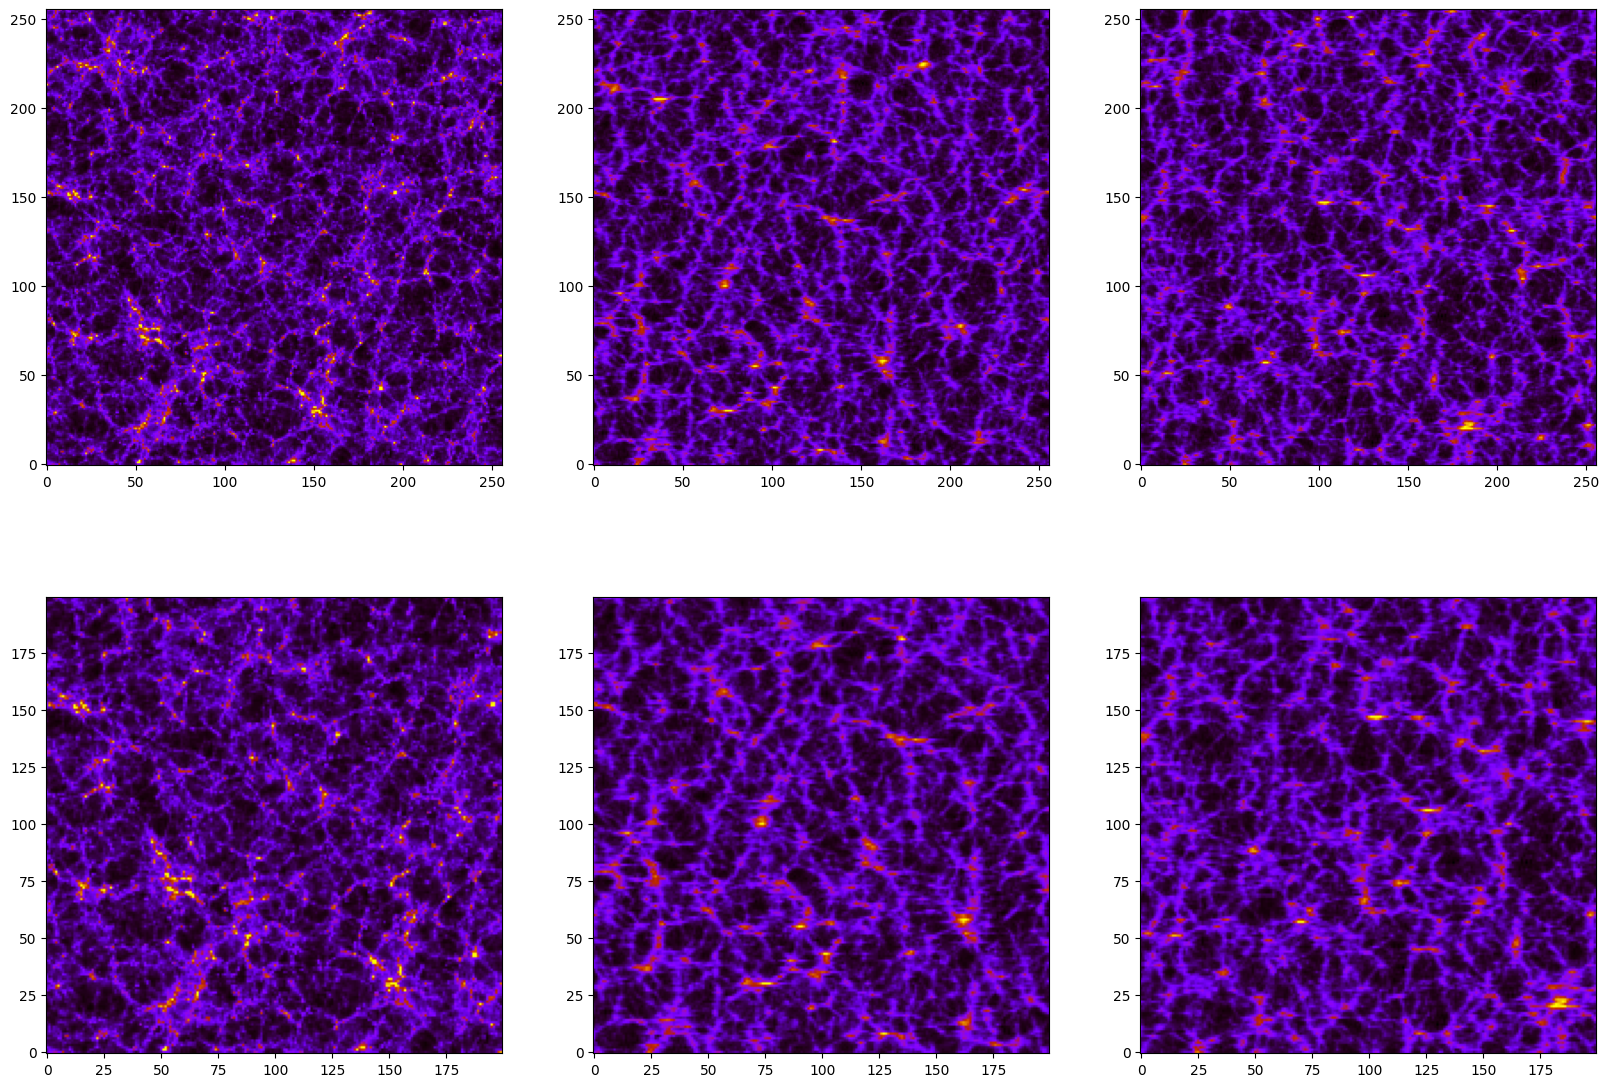

In [182]:
df_x = np.mean(rho_z[:5,:,:]+1,axis=0) #projection into the YZ plane
df_y = np.mean(rho_z[:,:5,:]+1,axis=1) #projection into the XZ plane
df_z = np.mean(rho_z[:,:,:5]+1,axis=2) #projection into the XY plane

import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,14))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
ax1.imshow(df_x.T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax2.imshow(df_y.T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax3.imshow(df_z.T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax4.imshow(df_x[:200,:200].T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax5.imshow(df_y[:200,:200].T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax6.imshow(df_z[:200,:200].T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
plt.show()

As can be seen, the images in the middle and right columns are blurrier than the ones of the left column. This is due to the effects of the redshift-space distortions along that are placed along the X axis.

In [86]:
axis=0
Pk_z = PKL.Pk(rho_z-1, BoxSize, axis, MAS, threads, verbose)

k_z       = Pk_z.k3D
Pk0_z     = Pk_z.Pk[:,0] #monopole
Pk2_z     = Pk_z.Pk[:,1] #quadrupole
Pk4_z     = Pk_z.Pk[:,2] #hexadecapole


Computing power spectrum of the field...
Time to complete loop = 3.34
Time taken = 4.17 seconds


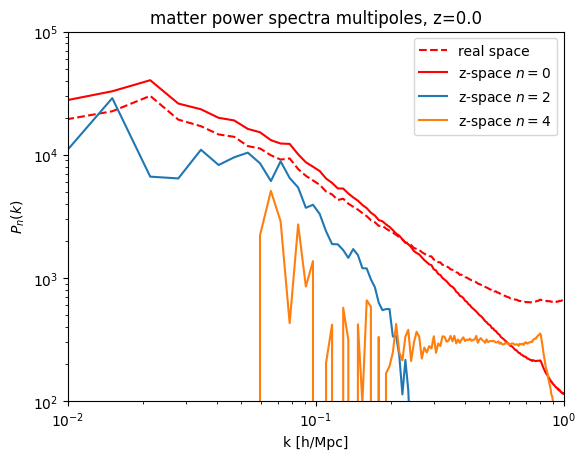

In [95]:
plt.plot(k,Pk0,'r--',label='real space')
plt.plot(k_z,Pk0_z,'r-',label=r'z-space $n=0$')
plt.plot(k_z,Pk2_z,label=r'z-space $n=2$')
plt.plot(k_z,Pk4_z,label=r'z-space $n=4$')
# plt.loglog(k,Pk2_z,'r-',label='mm quadru')
plt.xlim(1e-2,1)
plt.ylim(1e2,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k [h/Mpc]')
plt.ylabel('$P_{n}(k)$')
plt.xscale('log')
plt.legend()
plt.title('matter power spectra multipoles, z='+str(np.round(redshift,2)))
plt.show()

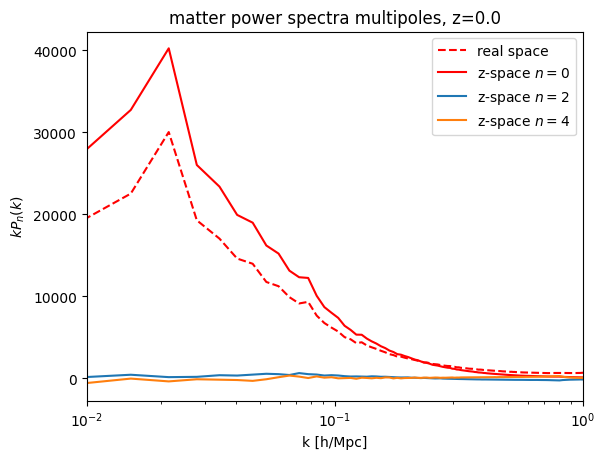

In [103]:
plt.plot(k,Pk0,'r--',label='real space')
plt.plot(k_z,Pk0_z,'r-',label=r'z-space $n=0$')
plt.plot(k_z,k_z*Pk2_z,label=r'z-space $n=2$')
plt.plot(k_z,k_z*Pk4_z,label=r'z-space $n=4$')
# plt.loglog(k,Pk2_z,'r-',label='mm quadru')
plt.xlim(1e-2,1)
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlabel('k [h/Mpc]')
plt.ylabel('$k P_{n}(k)$')
plt.xscale('log')
plt.legend()
plt.title('matter power spectra multipoles, z='+str(np.round(redshift,2)))
plt.show()

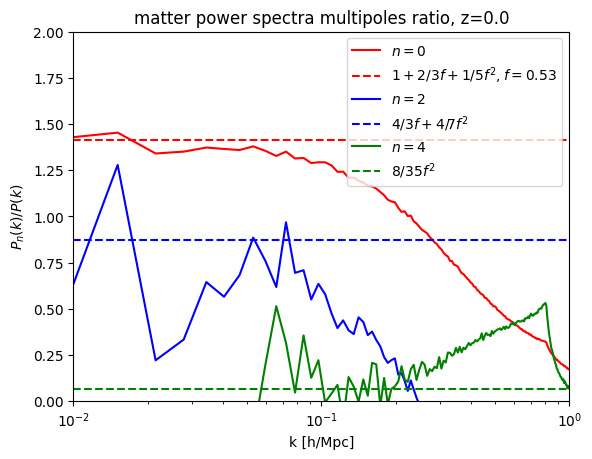

In [97]:
b1=1 #for matter
f=Omega_m**0.55
beta=f/b1
f0=1+2/3*beta+1/5*beta**2
f2=4/3*beta+4/7*beta**2
f4=8/35*beta**2
plt.plot(k_z,Pk0_z/np.interp(k_z,k,Pk0),'r-',label='$n=0$')
plt.axhline(f0,color='r',linestyle='--',label=r'$1+2/3f+1/5f^2, f=$'+str(np.round(beta,2)))
plt.plot(k_z,Pk2_z/np.interp(k_z,k,Pk0),'b-',label='$n=2$')
plt.axhline(f2,color='b',linestyle='--',label=r'$4/3f+4/7f^2$')
plt.plot(k_z,Pk4_z/np.interp(k_z,k,Pk0),'g-',label='$n=4$')
plt.axhline(f4,color='g',linestyle='--',label=r'$8/35f^2$')

# plt.loglog(k,Pk2_z,'r-',label='mm quadru')
plt.xlim(1e-2,1)
plt.ylim(0,2)
plt.xlabel('k [h/Mpc]')
plt.ylabel('$P_{n}(k)/P(k)$')
plt.xscale('log')
plt.legend()
plt.title('matter power spectra multipoles ratio, z='+str(np.round(redshift,2)))
plt.show()

### Compute difference between real and redshift space position

In [89]:
diffpos=np.unwrap((pos_real-pos)[:,0],period=BoxSize)

In [90]:
np.max(diffpos),np.min(diffpos)

(np.float64(57.05000305175781), np.float64(-58.649993896484375))

In [91]:
np.mean(np.abs(diffpos))

np.float64(2.894271869381055)

Text(0, 0.5, '$P(x-x_z)$')

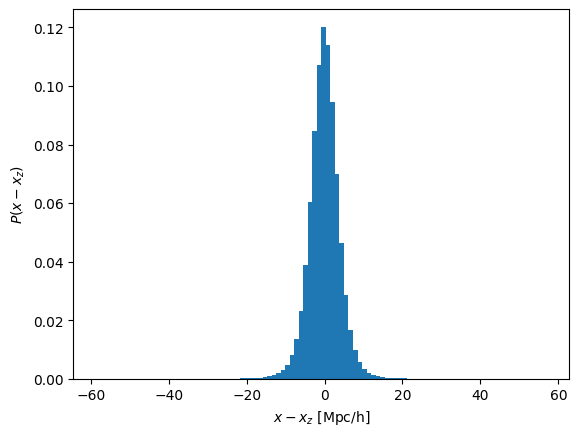

In [92]:
counts_diffpos,bin_edges_diffpos,_=plt.hist(diffpos,density=True,bins=100)
plt.xlabel(r'$x-x_z$ [Mpc/h]')
plt.ylabel(r'$P(x-x_z)$')

Text(0, 0.5, '$P(|x-x_z|)$')

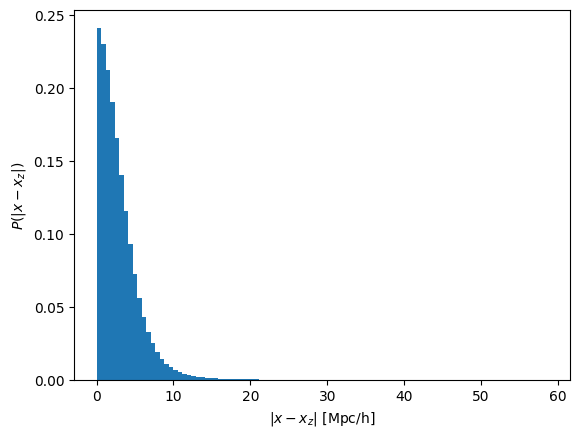

In [93]:
counts_diffpos,bin_edges_diffpos,_=plt.hist(np.abs(diffpos),density=True,bins=100)
plt.xlabel(r'$|x-x_z|$ [Mpc/h]')
plt.ylabel(r'$P(|x-x_z|)$')

In [94]:
np.corrcoef(rho.flatten(),rho_z.flatten())

array([[1.      , 0.741691],
       [0.741691, 1.      ]])

## Displacements Matter

In [51]:
snapshot_ini = 'Data/Snapshots/'+cos+'/'+str(realisation)+'/ICs/ics'
header_ini   = readgadget.header(snapshot_ini)
pos_m_ini = readgadget.read_block(snapshot_ini, "POS ", ptype)/1e3 #positions in Mpc/h
ids_ini = readgadget.read_block(snapshot_ini, "ID  ", ptype)-1   #IDs starting from 0
pos_m_ini_sorted=pos_m_ini[np.argsort(ids_ini)]

pos_m = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0
# Nall     = header.nall         #Total number of particles
pos_m_sorted=pos_m[np.argsort(ids)]

In [52]:
displacement=pos_m_sorted-pos_m_ini_sorted

In [53]:
np.max(displacement),np.min(displacement),np.mean(displacement)

(np.float32(999.992), np.float32(-999.9996), np.float32(-0.039106455))

In [54]:
displacement=np.zeros(np.shape(pos_m_sorted))
for i in range(2):
    displacement[:,i]=np.unwrap(pos_m_sorted[:,i]-pos_m_ini_sorted[:,i],period=BoxSize)

In [55]:
np.max(displacement)

np.float64(38.55078125)

In [56]:
dist = np.linalg.norm(displacement,axis=-1)

In [57]:
np.min(dist),np.max(dist)

(np.float64(2.1579186437577746e-05), np.float64(38.55642797803628))

In [59]:
np.mean(dist),np.std(dist)

(np.float64(7.209660611290966), np.float64(3.8587730083429155))

Text(0, 0.5, '$P(x-q)$')

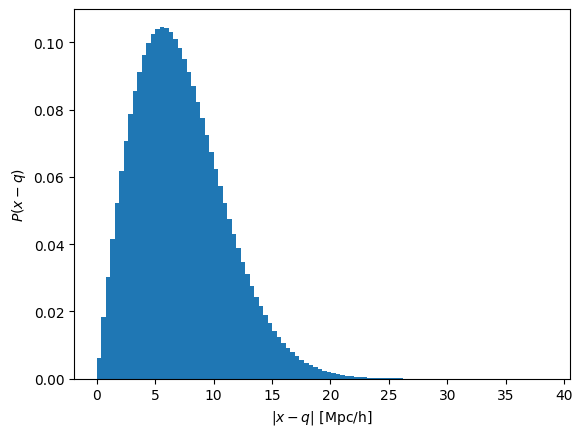

In [58]:
counts_dist,bin_edges_dist,_=plt.hist(dist,density=True,bins=100)
plt.xlabel(r'$|x-q|$ [Mpc/h]')
plt.ylabel(r'$P(x-q)$')

In [60]:
rho_ini = np.zeros((N_grid,N_grid,N_grid), dtype=np.float32)
MASL.MA(pos_m_ini, rho_ini, BoxSize, MAS, verbose=verbose)
# at this point, delta contains the effective number of particles in each voxel
# now compute overdensity
print(np.mean(rho_ini))
rho_ini /= np.mean(rho_ini, dtype=np.float64)


Using CIC mass assignment scheme
Time taken = 5.255 seconds

64.00001


In [61]:
axis=0
Pk_ini = PKL.Pk(rho_ini-1, BoxSize, axis, MAS, threads, verbose)

k_ini      = Pk_ini.k3D
Pk0_ini     = Pk_ini.Pk[:,0] #monopole



Computing power spectrum of the field...
Time to complete loop = 0.15
Time taken = 0.18 seconds


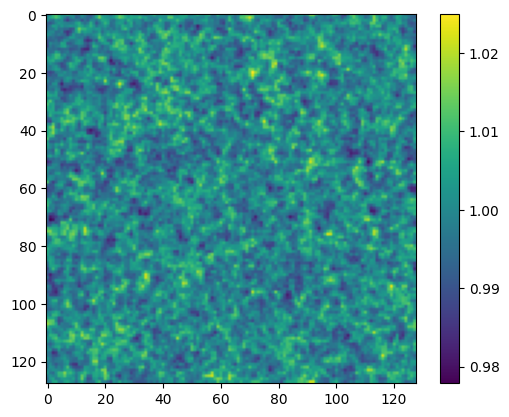

In [62]:
mean_density_ini = np.mean(rho_ini[:5,:,:],axis=0) #Take the first 5 component along the first axis and compute the mean value
plt.imshow(mean_density_ini.T)
plt.colorbar()
plt.show()

## Halos

In [62]:
cos='fiducial'
import readfof
#Read halo catalog at given redshift and find array of particle IDs corresponding to halos

halosnapdir_ids='Data/Halos/FoF_id/'+cos+'/'+str(realisation)
FoF_id = readfof.FoF_catalog(halosnapdir_ids, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=True)

pos_h = FoF_id.GroupPos/1e3            #Halo positions in Mpc/h
mass_h  = FoF_id.GroupMass*1e10          #Halo masses in Msun/h
vel_h = FoF_id.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
Npart = FoF_id.GroupLen                #Number of CDM particles in the halo


### Halo mass function

In [47]:
np.min(np.log10(mass_h)), np.max(np.log10(mass_h))

(np.float32(13.118305), np.float32(15.737912))

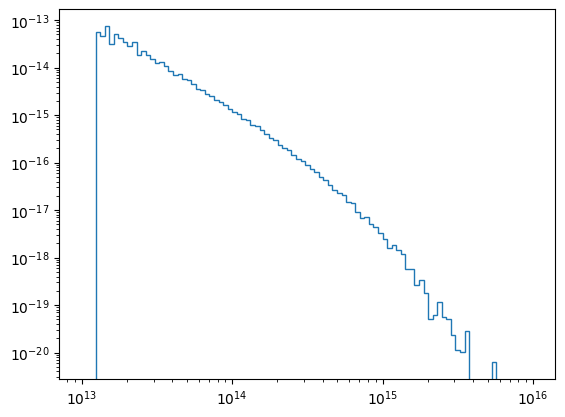

In [48]:
binHMF_edges=np.logspace(13,16,100,base=10)
binHMF_mids=1/2*(binHMF_edges[1:]+binHMF_edges[:-1])
binHMF_widths = np.diff(binHMF_edges)

counts,binHMF_edges,_=plt.hist(mass_h,bins=binHMF_edges,density=True,histtype='step')
# plt.plot(binHMF_mids,counts/binHMF_widths)

plt.xscale('log')
plt.yscale('log')

In [49]:
import mass_function_library as MFL
import cosmology_library as CL

# halo mass function parameters
cos='fiducial'
f_Pk   = 'Data/Linear_Pk/'+cos+'/CAMB_TABLES/CAMB_matterpow_0.dat'  #file with linear Pk
OmegaM = Omega_m
Masses = np.logspace(13, 15, 100,base=10) #array with halo masses
author = 'ST'   #Sheth-Tormen halo mass function
bins   = 1000  #number of bins to use for Pk
z      = 0.0    #redshift; only used for Tinker, Tinker10 and Crocce
delta  = 200.0  #overdensity; only for Tinker and Tinker10

D127 = CL.linear_growth_factor(127, Omega_m, Omega_l)

# read linear matter Pk
k, Pk = np.loadtxt(f_Pk, unpack=True)
# plt.loglog(k, Pk)
# # plt.loglog(k_ini,Pk0_ini/D127**2,label='ini conditions $/D(z=127)^2$')
# plt.legend()
# plt.show()
# compute halo mass function
HMF = MFL.MF_theory(k, Pk, OmegaM, Masses, author, bins, z, delta)


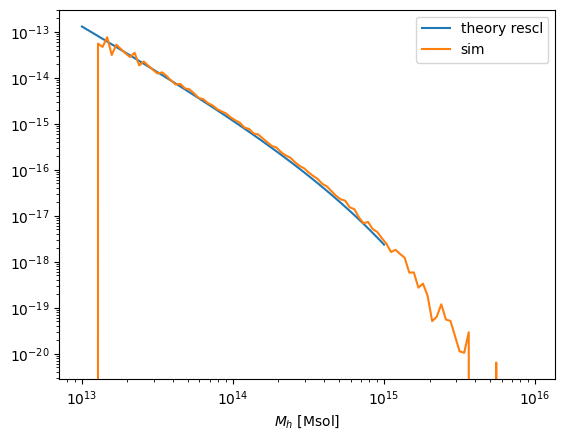

In [50]:
# plt.loglog(Masses,HMF,label='theory')
MassesbinHMF_mids=1/2*(Masses[1:]+Masses[:-1])
MassesbinHMF_width = np.interp(Masses,binHMF_mids,np.diff(Masses))
plt.loglog(Masses,HMF/np.sum(MassesbinHMF_width*HMF),label='theory rescl')

# plt.hist(mass_h,bins=binsHMF,density=True,histtype='step',label='sim')
plt.plot(binHMF_mids,counts,label='sim')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_h$ [Msol]')
plt.legend()

### Power spectra

In [63]:
rho_h = np.zeros((N_grid,N_grid,N_grid),dtype=np.float32)
MASL.MA(pos_h,rho_h,BoxSize,MAS)
rho_h /= np.mean(rho_h, dtype=np.float32)

In [64]:
Pk_hm = PKL.XPk([rho-1,rho_h-1], BoxSize, axis, [MAS,MAS], threads)
k_hm       = Pk_hm.k3D

Pk0_mm  = Pk_hm.Pk[:,0,0]  #monopole of field 1
Pk0_hh  = Pk_hm.Pk[:,0,1]  #monopole of field 2
Pk0_hm  = Pk_hm.XPk[:,0,0] #monopole of 1-2 cross P(k)


Computing power spectra of the fields...
Time FFTS = 1.86
Time loop = 3.13
Time taken = 5.00 seconds


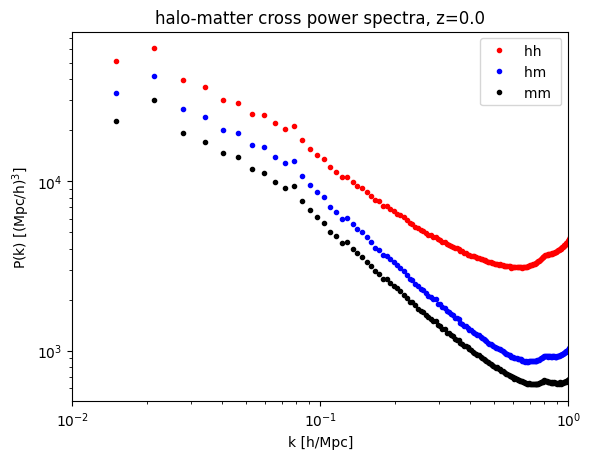

In [75]:
plt.loglog(k_hm,Pk0_hh,'r.',label='hh ')
plt.loglog(k_hm,Pk0_hm,'b.',label='hm ')
plt.loglog(k_hm,Pk0_mm,'k.',label='mm ')
plt.xlim(1e-2,1)
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)$^3$]')
plt.legend()
plt.title('halo-matter cross power spectra, z='+str(np.round(redshift,2)))
plt.show()

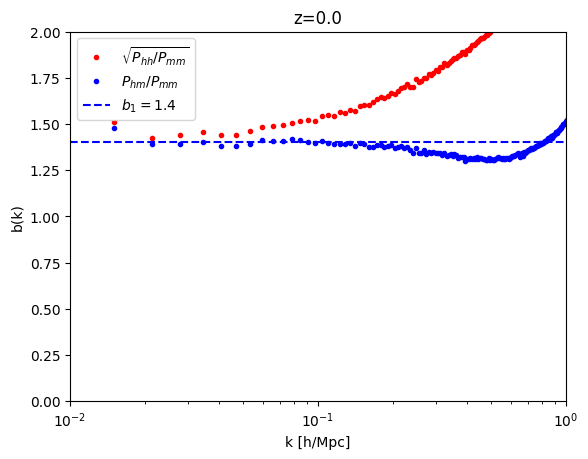

In [77]:
b1h=1.4
plt.plot(k_hm,np.sqrt(Pk0_hh/Pk0_mm),'r.',label=r'$\sqrt{P_{hh}/P_{mm}}$')
plt.plot(k_hm,Pk0_hm/Pk0_mm,'b.',label=r'$P_{hm}/P_{mm}$')
plt.axhline(b1h,label='$b_1=$'+str(b1h),color='b',linestyle='--')
plt.xlim(1e-2,1)
plt.ylim(0,2)
plt.xscale('log')
plt.legend()
plt.title('z='+str(np.round(redshift,2)))
plt.xlabel('k [h/Mpc]')
plt.ylabel('b(k)')
plt.show()

In [117]:
nhalo=len(pos_h)/BoxSize**3
nhalo

np.float64(0.000406621)

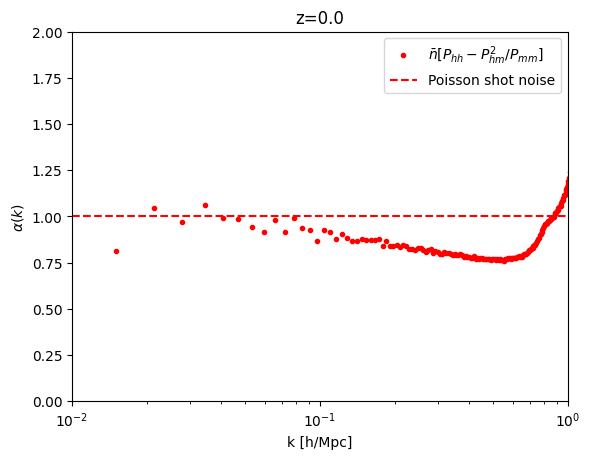

In [79]:
plt.plot(k_hm,(Pk0_hh-Pk0_hm**2/Pk0_mm)*nhalo,'r.',label=r'$\bar n[P_{hh}-P_{hm}^2/P_{mm}]$')
# plt.plot(k_hm,Pk0_hm/Pk0_mm,'b.',label='hm ')
plt.axhline(1,label='Poisson shot noise',color='r',linestyle='--')
plt.xlim(1e-2,1)
plt.ylim(0,2)
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$\alpha(k)$')
plt.legend()
plt.title('z='+str(np.round(redshift,2)))
plt.show()

### Redshift space power spectra

In [81]:
import redshift_space_library as RSL
# move halos to redshift-space. After this call, pos_h will contain the
# positions of the halos in redshift-space
axis = 0 #axis along which to displace halos
RSL.pos_redshift_space(pos_h, np.float32(vel_h), BoxSize, Hubble, redshift, axis)
rho_h_z = np.zeros((N_grid,N_grid,N_grid),dtype=np.float32)
MASL.MA(pos_h,rho_h_z,BoxSize,MAS)
rho_h_z /= np.mean(rho_h_z, dtype=np.float32)

In [101]:
Pk_hm_z = PKL.XPk([rho_z-1,rho_h_z-1], BoxSize, axis, [MAS,MAS], threads)
k_hm_z       = Pk_hm_z.k3D
# Pk0_hm_ini     = Pk_hm_ini.Pk[:,0] #monopole

Pk0_hh_z  = Pk_hm_z.Pk[:,0,1]  #monopole of field 2
Pk2_hh_z  = Pk_hm_z.Pk[:,1,1]  #monopole of field 2
Pk4_hh_z  = Pk_hm_z.Pk[:,2,1]  #monopole of field 2


# Pk0_mm  = Pk_hm.Pk[:,0,0]  #monopole of field 1
# Pk0_hh  = Pk_hm.Pk[:,0,1]  #monopole of field 2
Pk0_hm_z  = Pk_hm.XPk[:,0,0] #monopole of 1-2 cross P(k)


Computing power spectra of the fields...
Time FFTS = 1.97
Time loop = 1.26
Time taken = 3.25 seconds


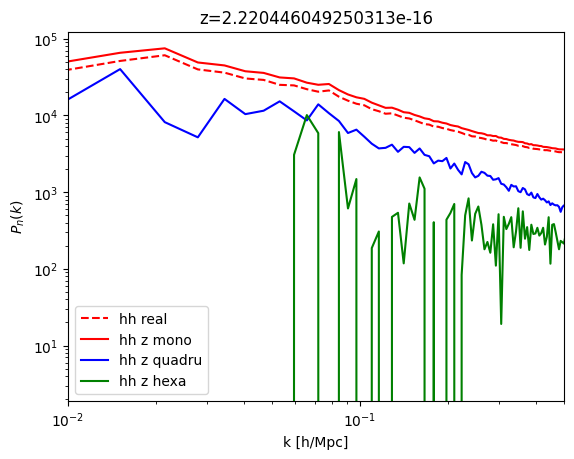

In [112]:
plt.loglog(k_hm,Pk0_hh,'r--',label='hh real')
plt.loglog(k_hm_z,Pk0_hh_z,'r-',label='hh z mono')
plt.loglog(k_hm_z,Pk2_hh_z,'b-',label='hh z quadru')
plt.loglog(k_hm_z,Pk4_hh_z,'g-',label='hh z hexa')
plt.xlim(1e-2,0.5)
plt.xlabel('k [h/Mpc]')
plt.ylabel('$P_{n}(k)$')
plt.legend()
plt.title('z='+str(redshift))
plt.show()

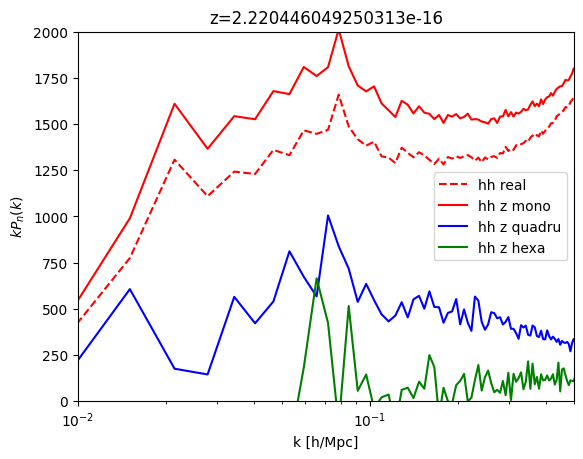

In [111]:
plt.plot(k_hm,k_hm*Pk0_hh,'r--',label='hh real')
plt.plot(k_hm_z,k_hm_z*Pk0_hh_z,'r-',label='hh z mono')
plt.plot(k_hm_z,k_hm_z*Pk2_hh_z,'b-',label='hh z quadru')
plt.plot(k_hm_z,k_hm_z*Pk4_hh_z,'g-',label='hh z hexa')
plt.xlim(1e-2,0.5)
plt.ylim(0,2*1e3)
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel('$k P_{n}(k)$')
plt.legend()
plt.title('z='+str(redshift))
plt.show()

In [248]:
import cosmology_library as CL
# compute the linear growth factor
D = CL.linear_growth_factor(z, Omega_m, Omega_l)
print(D)

[1.]


In [260]:
D127 = CL.linear_growth_factor(127, Omega_m, Omega_l)
D127

array([0.00989872])

Text(0.5, 1.0, 'halo power spectra multipoles ratio, z=0.0')

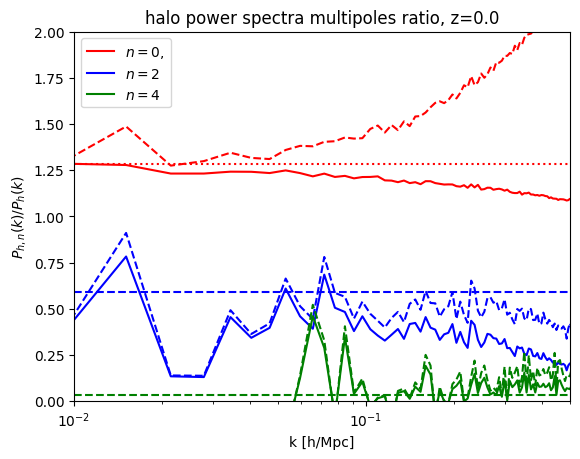

In [116]:
b1=b1h
f=Omega_m**0.55
beta=f/b1h
f0=(1+2/3*beta+1/5*beta**2)
f2=(4/3*beta+4/7*beta**2)
f4=(8/35*beta**2)

plt.plot(k_hm_z,Pk0_hh_z/np.interp(k_hm_z,k_hm,Pk0_hh),'r-',label='$n=0$,')
plt.plot(k_hm_z,Pk0_hh_z/np.interp(k_hm_z,k_hm,Pk0_mm*b1h**2),'r--')#,label='$n=0, P_h=b^2P_m$')
plt.axhline(f0,color='r',linestyle=':')#,label=r'$1+2/3\beta+1/5\beta^2, \beta=$'+str(np.round(beta,2)))

plt.plot(k_hm_z,Pk2_hh_z/np.interp(k_hm_z,k_hm,Pk0_hh),'b-',label='$n=2$')
plt.plot(k_hm_z,Pk2_hh_z/np.interp(k_hm_z,k_hm,Pk0_mm*b1h**2),'b--')#,label='$n=2, P_h=b^2P_m$')
plt.axhline(f2,color='b',linestyle='--')#,label=r'$4/3\beta+4/7\beta^2$')

plt.plot(k_hm_z,Pk4_hh_z/np.interp(k_hm_z,k_hm,Pk0_hh),'g-',label='$n=4$')
plt.plot(k_hm_z,Pk4_hh_z/np.interp(k_hm_z,k_hm,Pk0_mm*b1h**2),'g--')#,label='$n=4, P_h=b^2P_m$')
plt.axhline(f4,color='g',linestyle='--')#,label=r'$8/35\beta^2$')

plt.xlim(1e-2,0.5)
plt.ylim(0,2)
plt.xlabel('k [h/Mpc]')
plt.ylabel('$P_{h,n}(k)/P_h(k)$')
plt.xscale('log')
plt.legend()
plt.title('halo power spectra multipoles ratio, z='+str(np.round(redshift,2)))

## Bispectrum

In [120]:
from scipy.interpolate import CubicSpline

# k, P_lin = np.loadtxt('Plinear.dat',unpack=True)
cos='fiducial'
k, P_lin = np.loadtxt('Data/Linear_Pk/'+cos+'/CAMB_TABLES/CAMB_matterpow_0.dat', unpack=True)  #file with linear Pk

Pk_lin = CubicSpline(k, P_lin )
k_min = np.min(k)
k_min

# Using (k1+k2)^2 = k3^2:
def alpha(k1,k2,k3):
    return  1 + 0.5*(k3**2 - k1**2 - k2**2)/k1**2
def beta(k1,k2,k3):
    return (k1 + k2)**2*(k3**2 - k1**2 - k2**2)/(4*k1**2*k2**2)

def F2(k1,k2,k3):
    # return 1/7*(5/2*alpha(k1, k2,k3) + 5/2*alpha(k2, k1,k3) + 2*beta(k1, k2,k3))
    return (5/7*alpha(k1, k2,k3) + 5/7*alpha(k2, k1,k3) + 2/7*beta(k1, k2,k3))

def B_tree(k1,k2,k3):
    return 2*(F2(k1,k2,k3)*Pk_lin(k1)*Pk_lin(k2)+F2(k1,k3,k2)*Pk_lin(k1)*Pk_lin(k3)+F2(k3,k2,k1)*Pk_lin(k3)*Pk_lin(k2)) 

In [118]:
k1      = 0.05#0.5    #h/Mpc
k2      = 0.05 #0.6    #h/Mpc
MAS     = 'CIC'
threads = 1
theta   = np.linspace(0, np.pi, 25) #array with the angles between k1 and k2

# compute bispectrum
BBk = PKL.Bk(rho-1, BoxSize, k1, k2, theta, MAS, threads)
Bk  = BBk.B     #bispectrum
Qk  = BBk.Q     #reduced bispectrum
k   = BBk.k     #k-bins for power spectrum
Pk  = BBk.Pk    #power spectrum



Computing bispectrum of the field...
Time to compute bispectrum = 54.45


In [43]:
def anglefromlenghts(k1,k2,k3):
    return np.arccos((k2**2+k1**2-k3**2)/(2*k1*k2))

def lengthfromangle(k1,k2,theta):
    k3=np.sqrt(k1**2+k2**2-2*k1*k2*np.cos(theta))
    return k3

/tmp/ipykernel_1956/2114859292.py:13: RuntimeWarning: invalid value encountered in divide
  return  1 + 0.5*(k3**2 - k1**2 - k2**2)/k1**2
/tmp/ipykernel_1956/2114859292.py:15: RuntimeWarning: invalid value encountered in divide
  return (k1 + k2)**2*(k3**2 - k1**2 - k2**2)/(4*k1**2*k2**2)


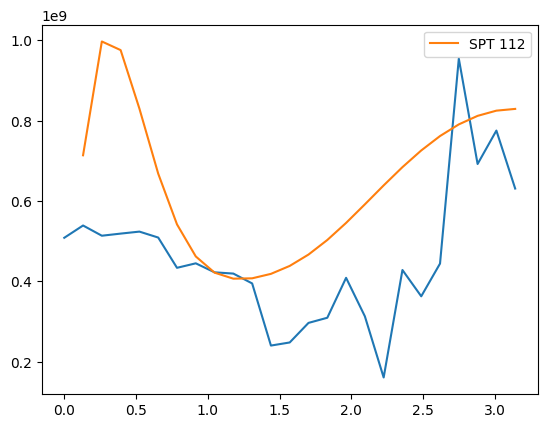

In [121]:
plt.plot(theta,Bk)
test=B_tree(k1,k2,lengthfromangle(k1,k2,theta))
plt.plot(theta,test,label='SPT 112')
plt.legend()

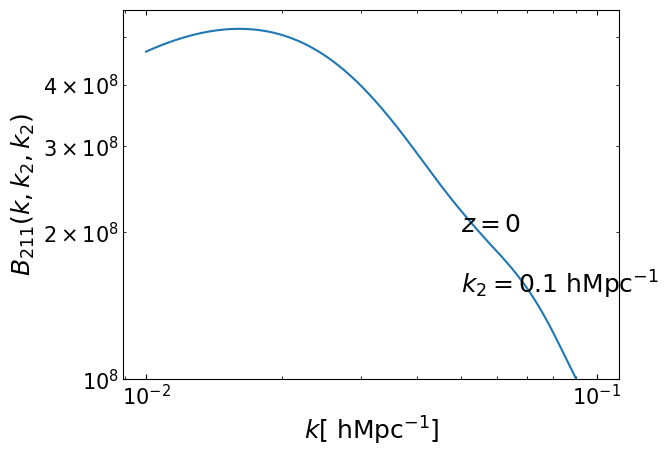

In [45]:
kmin, kmax, nk = 0.01, 0.1, 500#1e-4, 1e3, 144
k1_values = np.linspace(kmin,kmax,nk)#np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
k_2 = 0.1
k_3 = 0.1 

plt.plot(k1_values,B_tree(k1_values,k_2,k_3))
plt.text(0.05,2e8, r'$z=0$',fontsize=18)

plt.text(0.05,1.5e8, r'$k_2=%s$ hMpc$^{-1}$'%k_2,fontsize=18)


plt.xscale('log')
plt.yscale('log')
plt.ylim(1e8,)
plt.xlabel(r'$k[$ hMpc$^{-1}]$',fontsize=18)
plt.ylabel(r'$B_{211}(k,k_2,k_2)$',fontsize=18)
plt.tick_params(direction='in',which='both', top = True, right = True, labelsize=15)
plt.savefig('Tree_level_bispectrum.pdf')

In [ ]:
"""
This code takes the linear power spectrum of matter (e. g. from a Boltzman solver like CAMB)
and convolves it into its one loop correction by integrating in log k 
"""

import numpy as np
from scipy.integrate import simps
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy import interpolate
import analyticpower
from multiprocessing import Pool


# Definiendo una funcion que sea el espectro lineal
def linearpower(q):
    if q<0:
        print('k negativa')
        power = 0.
    elif q < qmin:
        power = power_rate_ini*ana.Phs(q)
        #power = power_ini
    elif q> qmax:
        #power = power_end
        power = power_rate_end*ana.Phs(q)
    else:
        power = interpolate.splev(q,tck,der=0)
    return power


def xargument(x,q,k):
    r = q/k
    den = 1. + r**2 - 2.*r*x
    factorx = (3.*r + 7.*x - 10.*r*x**2)**2/den**2
    xargument = linearpower(k*np.sqrt(den))*factorx
    return xargument

def p22_argument(q,k):
    r = q/k
    # The next is to integrate only over the numerical part of P
    #rmin = qmin/k
    #rmax = qmax/k
    #x_bis_min = max(-1.,(1.+r**2-rmax**2)/(2.*r))
    #x_bis_max = min(0.9999999,(1.+r**2-rmin**2)/(2.*r))
    # I use this limits if I trust the analytical extension of P
    x_bis_min = -1.
    x_bis_max = min(0.999999,1/(r*2))
    # We make the integral over x using the interpolated powerspectrum
    xintegral = quad(xargument,x_bis_min,x_bis_max,args=(q,k))[0]
    return xintegral
    
def p22(k):
    aux0 = p22_argument(ktabla,k)
    p22_arg = aux0*ptabla
    p22_integral = simps(p22_arg,ktabla)
    #print('Computing P22 for k = ',k)
    p22 = 2./98.*k**2/(4.*np.pi**2)*p22_integral
    # This last step is to put everything back in CAMB like units
    p22 = p22*h**3
    return p22

def p13_argument(q,k):
    """
    Kernels of the P13 integral with their respective aproximations around particular values
    """
    r = q/k
    if r < 5e-3:
        factor = -2./3. + 232./315.*r**2 - 376./735.*r**4
        #-168. + 928./5.*r**2 - 4512./35.*r**4 + 416./21.*r**6
    elif abs(r-1.) < 3e-3:
        factor = (-22. + 2.*(r-1.) - 29.*(r-1.)**2)/63.
        #factor = -88. + 8.*(r-1.)
    elif r > 500.:
        s = 1./r
        factor = -122./315. + 8./105.*s**2 - 40./1323.*s**4
        #factor = -488./5. + 96./5./r**2 - 160./21./r**4 - 1376./1155./r**6
    else:
        factor = (12./r**2 - 158. + 100.*r**2 - 42.*r**4 + 3./r**3*(r**2-1.)**3*(7.*r**2+2.)*np.log(abs((1.+r)/(1.-r))))/252.
    return factor


def p13(k):
    aux1 = p13_argument(ktabla,k)
    p13_arg = aux1*ptabla
    second_integral = simps(p13_arg,ktabla)
    # print 'Computing P13 for k =',k
    p13 = k**2/(2.*np.pi)**2*linearpower(k)*second_integral
    # This last step is to put everything in CAMB like units
    p13 = p13*h**3
    return p13

"""
Computing one loop correciton of the matter large scale structure power spectrum.
Several cosmological constants are defined in analyticpower.py, go there if you want to change them.
"""
h = 0.6790

# Initializing both numerical and analyic linear powerspectrum
# the function linearpower uses both at appropiate regions


ana = analyticpower.AnalyticPower()
tabla = np.loadtxt("planck_linear.dat")
ktabla = tabla[:,0]*h
ptabla = tabla[:,1]*h**(-3)
tck=interpolate.splrep(ktabla,ptabla,s=0)

# Adjusting the limits between numerical and analytical
qmin = ktabla[0]
qmax = ktabla[-1]
power_ini = ptabla[0]
power_end = ptabla[-1]
power_rate_ini = ptabla[0]/ana.Phs(ktabla[0])
power_rate_end = ptabla[-1]/ana.Phs(ktabla[-1])

# Computing the one-loop corrections
p13_argument = np.vectorize(p13_argument)
p22_argument = np.vectorize(p22_argument)
    
if __name__ == '__main__':

    p = Pool(4)
    p22_tabla = p.map(p22,ktabla)
    p13_tabla = p.map(p13,ktabla)

    # This last step is to put everything back in CAMB-like units
    ptabla = ptabla*h**3
    ktabla = ktabla/h
    np.savetxt("./oneloop_Pk.dat",np.transpose([ktabla,ptabla,p22_tabla,p13_tabla]))


